In [1]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 17:27:34


In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    # Set up directory
    os.makedirs(housing_path, exist_ok = True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    # Put tgz in directory
    urllib.request.urlretrieve(housing_url, tgz_path)
    # Unzip tgz file into directory
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [3]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    # Return .csv file read by Pandas
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
# head() looks at the top (in this case 5) entries of a dataset
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# info() is used to get quick description of data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# value_counts() shows info about each attribute's unique data entries
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# describe() shows summary of the numerical attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


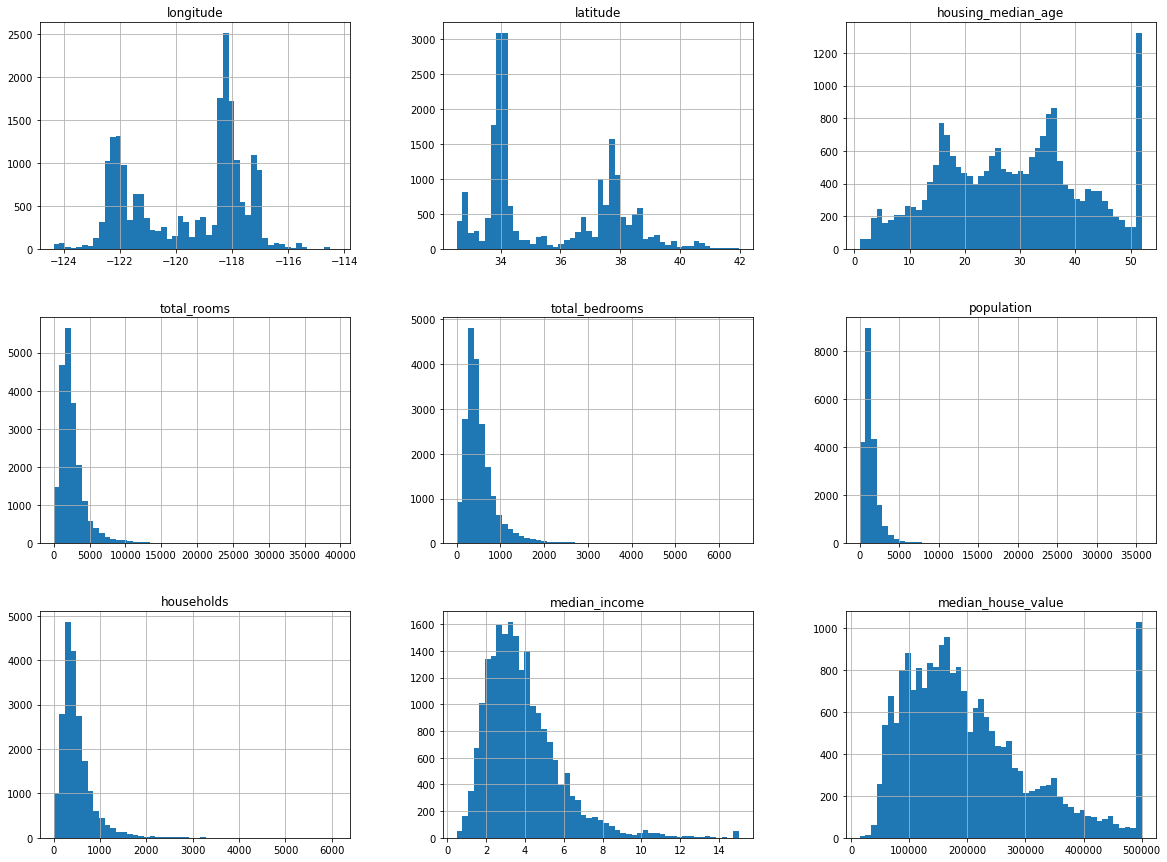

In [8]:
# (exclusive to jupyter) matplotlib needs a GUI backend to draw; code tells matplotlib to use Jupyter's GUI backend
%matplotlib inline 
import matplotlib.pyplot as plt
# Histograms are a good visual representation of the different entries in each attribue
housing.hist(bins = 50, figsize = (20, 15))
# Y-axis represents number of instances, X-axis represents range of values
plt.show()

In [9]:
# Naive non-dynamic way to create test set made up of random 20% of the dataset. 
import numpy as np

def split_train_test(data, test_ratio):
    # Create array of indices for each entry in dataset, but shuffled up
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    # iloc[] is used as INDEX in "data[INDEX]" as normal int index not used (in this case, we are passing in an array as INDEX)
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), " ", len(test_set))

16512   4128


In [11]:
# More dynamic way to produce the same test set made up of random 20% of a (potentially) changing dataset
# We compute the hash of each instance (row/district) identifier and if hash value <= 0.2 * max_hash_value we add it to test set
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
# Now we can create out test and train sets with dynamic datasets while making sure they always produce the same sets everytime 
# for each dataset
housing_with_id = housing.reset_index() # adds an "index" column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [13]:
# The previous approach requires that there are no empty instances (rows/districts) so that the index column has no null entries
# To create a more stable column of indexes instead of reset_index(), combine other stable columns to create a composite column
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [14]:
# Of course, the best approach is leave it to the smarter 200IQ folks to make a method for you that creates train/test sets
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42) # random state is the seed for RNG

# Stratified Sampling
We don't want the test set to be comprised of 20% of entirely random entries from the dataset - we want to modify the test set so that it is a little biased to contain a more representative sample of the data (i.e. we want more of the common entries, and less of the rare entries). This is known as **Stratified Sampling**.

As an example, we'll divide the median_income column into categories that we can then apply these biases to so that the test data is more representative of the common and rare values in the datasets (We use median_income because our label is median housing price & median_income is an important attribute to determine this).

In [15]:
# We create 5 categories for income split up by 1.5 ($15,000) in difference
housing["income_cat"] = pd.cut(housing["median_income"], 
                              bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels = [1,2,3,4,5])

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index] # scope is global
    strat_test_set = housing.loc[test_index] # scope is global
    
# We'll print out the test_set.counts() as a decimal to show the percentage of each category in the test set
print (strat_test_set["income_cat"].value_counts() / len(strat_test_set))

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64


In [16]:
# Remember to always remove the category attribute (column) that was used for stratified samping from the new train/test sets
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover & Visualize the Data for insights

In [17]:
# Create a copy of the training set to explore with
housing = strat_train_set.copy();

Visualize geographical data

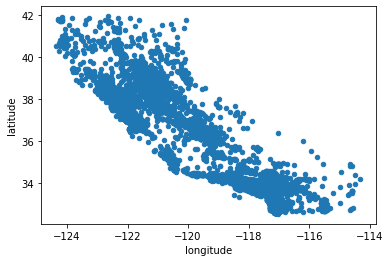

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude");

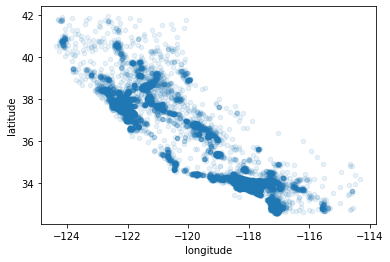

In [19]:
# Visualise high density points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ). Thanks to Wilmer Arellano for pointing it out.

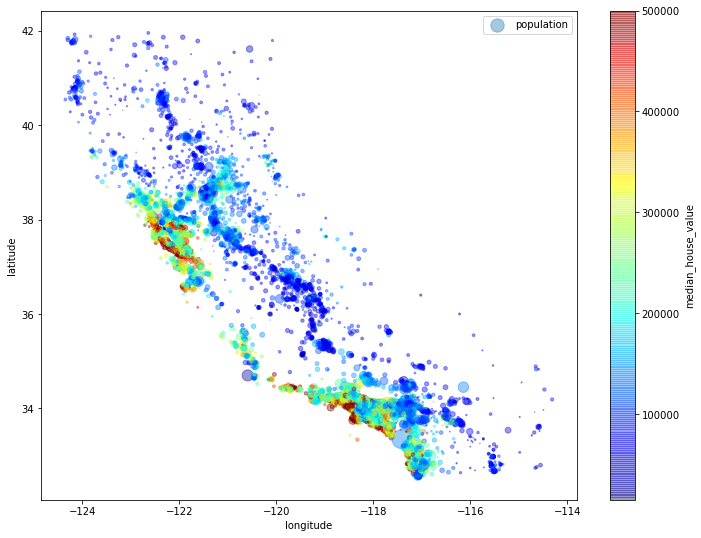

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", 
             figsize=(12,9), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False);
plt.legend();

We can tell that housing prices are related to the location (i.e. close to ocean) and to population. A clustering algorithm can identify main clusters and create new feature indicating how close each feature is to cluster center (price most likely would increase the close a feature is to a cluster). Note that we must pay attention to detail and not oversimply a correlation - e.g. incorrect to say houses closest to ocean are always more costly as northern coastal houses are comparitevly cheap.

Now we can look for correlations between attributes. Dataset isn't too large, so we can calculate Pearson's r (standard correlation coefficient) between every pair of attributres using the corr() method.

In [21]:
corr_matrix = housing.corr();
print(corr_matrix["median_house_value"].sort_values(ascending=False));

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64


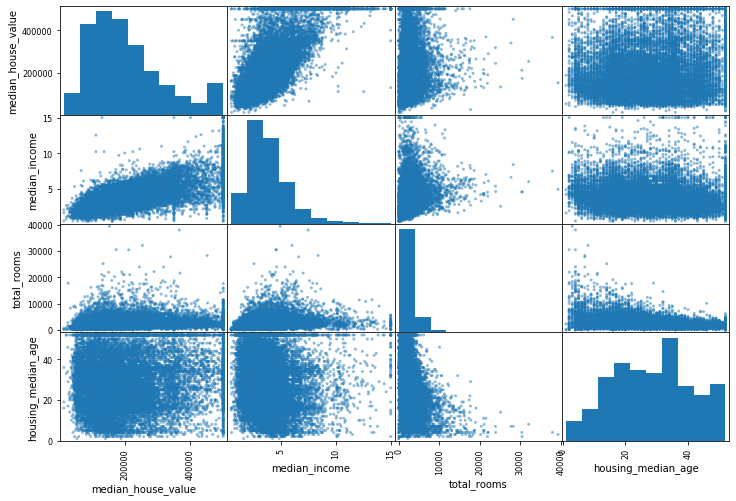

In [22]:
"""We can use pandas scatter_matrix() function for plotting every correlation between attributes, but that would 11^2 = 121! 
Lets just look at 11 correlations."""
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"];
scatter_matrix(housing[attributes], figsize=(12, 8));

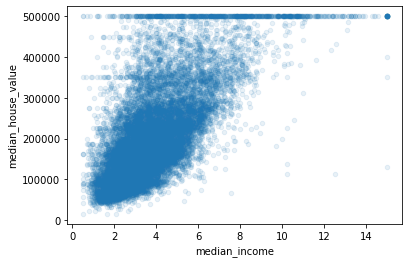

In [23]:
#median income looks most promising for predicting median house value so lets zoom into that
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1);

Two things to note here:
1. Upwards trend and point not too dispersed indicated strong correlation.
2. There is a visual cap at 500000 dollars, but there are other quirks such as horizontal lines at 450000, 350000 and maybe 
    280000 - might want to remove these correpsonding districts so the model doesn't reproduce these un-ideal patterns.
    
Now before we finish exploration, lets combine some attributes into more useful attributes that correlate more strongly with the target feature. For example, total number of rooms in a district is not useful without knowing how many households there are. Similarly, total number of bedrooms is not useful without knowing how many rooms there are, and populat per household may bear potential value too.

In [24]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"];
housing["bedrooms_per_household"] = housing["total_bedrooms"]/housing["total_rooms"];
housing["population_per_household"] = housing["population"]/housing["households"];

#Lets look at the correlations again
corr_matrix = housing.corr();
print(corr_matrix["median_house_value"].sort_values(ascending=False));

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_household     -0.259984
Name: median_house_value, dtype: float64


# Prepare Data for ML Algorithm
Lets clean the data. First we will handle missing features by creating a few function to take care of them; there are 3 ways to handle missing features:
1. Get rid of the corresponding district (this is seems to be common choice on Kaggle notebooks)
2. Get rid of the whole attribute
3. Set the values to some value (zero, mean attribute value, median attribute value etc.)

In [25]:
# Revert to a clean training set and separate the predictors and the labels
housing = strat_train_set.drop("median_house_value", axis=1);
housing_labels = strat_train_set["median_house_value"].copy();

In [28]:
# Option 1 via dropna() - housing.dropna(subset=["total_bedrooms"]);
# Option 2 via drop() - housing.drop("total_bedroom", axis=1);
# Option3 via fillna() - median = housing["total_bedrooms"].median(); housing["total_bedrooms"].fillna(median, inplace=True)

# If we choose option 3 i.e. fill missing values, we can us Scikit-Learn SimpleImputer to do that
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median");

# Median can only be computed on numerical attribute; ocean_promixity got to be removed for now
housing_num = housing.drop("ocean_proximity", axis=1);
imputer.fit(housing_num);

In [33]:
# statistics_ instance variable stores the imputer results
print(imputer.statistics_);
print(housing_num.median().values);

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [34]:
# Trained imputer now can be used to transform the training set by replacing missing values with median
X = imputer.transform(housing_num);
# imputer retruns a NumPy array, but we can do the following to return it back to a pandas DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index);